In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D
from sklearn.preprocessing import normalize

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D, MaxPool3D, UpSampling3D, GlobalAveragePooling3D
from keras import Sequential
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
import os

def load_files_list(directory):
    return os.listdir(directory)

In [3]:
autoencoder = Sequential()

autoencoder.add(Conv3D(8, (3,3,3), activation='relu', padding='same', input_shape=(16,28,128, 1))) 
autoencoder.add(MaxPool3D(pool_size=(2,2,2)))
autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
autoencoder.add(MaxPool3D(pool_size=(2,2,2)))

autoencoder.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))

autoencoder.add(UpSampling3D(size=2))
autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling3D(size=2))
autoencoder.add(Conv3D(8,(3,3,3), activation='relu', padding='same'))

autoencoder.add(Conv3D(1,(3,3,3), activation='relu', padding='same')) # Originally a Sigmoid

In [4]:
opt = keras.optimizers.Adam(learning_rate=0.001)


autoencoder.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')]

In [16]:
normal_path = '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id00/'
anomalies_path = '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id00/'
X_normal = []
X_abnormal = []

for audio in load_files_list(normal_path):
    array = np.load(normal_path + '/' + audio)
    array = array.reshape(16, 27, 128)
    for i in range(128):
        if np.max(array[:,:,i]) != 0:
            array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
    X_normal.append(array)
    
    
for audio in load_files_list(anomalies_path):
    array = np.load(anomalies_path + '/' + audio)
    array = array.reshape(16, 27, 128)
    for i in range(128):
        if np.max(array[:,:,i]) != 0:
            array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
    X_abnormal.append(array)


X_normal = np.asarray(X_normal) # This is to solve a problem with the upscailings.
X_normal = X_normal.reshape(X_normal.shape[0], 1, X_normal.shape[1], X_normal.shape[2], X_normal.shape[3])
Y = np.zeros([X_normal.shape[0], X_normal.shape[1], X_normal.shape[2], X_normal.shape[3] + 1, X_normal.shape[4]])
Y[:,:,:,:-1,:] = X_normal
X_normal = Y

X_abnormal = np.asarray(X_abnormal) # This is to solve a problem with the upscailings.
X_abnormal = X_abnormal.reshape(X_abnormal.shape[0], 1, X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3])
Y = np.zeros([X_abnormal.shape[0], X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3] + 1, X_abnormal.shape[4]])
Y[:,:,:,:-1,:] = X_abnormal
X_abnormal = Y

X_normal = X_normal.reshape(X_normal.shape[0], 16, 28, 128, 1)
X_abnormal = X_abnormal.reshape(X_abnormal.shape[0],16, 28, 128, 1)

X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.3, random_state=5) # Take a look at how it does the splitting.

In [17]:
history = autoencoder.fit(X_normal_train, X_normal_train, batch_size=45, epochs=40, callbacks=callbacks, validation_split=0.15)

Epoch 1/40
14/14 [==============================] - 116s 8s/step - loss: 0.0079 - mae: 0.0155 - val_loss: 0.0077 - val_mae: 0.0155
Epoch 2/40
14/14 [==============================] - 115s 8s/step - loss: 0.0077 - mae: 0.0162 - val_loss: 0.0075 - val_mae: 0.0183
Epoch 3/40
14/14 [==============================] - 116s 8s/step - loss: 0.0074 - mae: 0.0164 - val_loss: 0.0072 - val_mae: 0.0152
Epoch 4/40
14/14 [==============================] - 116s 8s/step - loss: 0.0070 - mae: 0.0148 - val_loss: 0.0067 - val_mae: 0.0139
Epoch 5/40
14/14 [==============================] - 116s 8s/step - loss: 0.0065 - mae: 0.0134 - val_loss: 0.0060 - val_mae: 0.0129
Epoch 6/40
14/14 [==============================] - 116s 8s/step - loss: 0.0052 - mae: 0.0123 - val_loss: 0.0045 - val_mae: 0.0112
Epoch 7/40
14/14 [==============================] - 116s 8s/step - loss: 0.0042 - mae: 0.0105 - val_loss: 0.0039 - val_mae: 0.0098
Epoch 8/40
14/14 [==============================] - 115s 8s/step - loss: 0.0037 - m

In [7]:
autoencoder.save('autoencoder_3d_fan_00.h5')

In [18]:
normal_predictions = autoencoder.predict(X_normal_test)

mse_list = []
mse_abnormal_list = []

for i in range (normal_predictions.shape[0]):
    x_reshaped = X_normal_test[i].reshape(16, 28*128)
    pred_reshaped = normal_predictions[i].reshape(16, 28*128)
    mse_list.append(mse(x_reshaped, pred_reshaped))
    
abnormal_predictions = autoencoder.predict(X_abnormal)

for i in range (abnormal_predictions.shape[0]):
    x_reshaped = X_abnormal[i].reshape(16, 28*128)
    pred_reshaped = abnormal_predictions[i].reshape(16, 28*128)
    mse_abnormal_list.append(mse(x_reshaped, pred_reshaped))

In [20]:
abnormal_predictions.shape

(407, 16, 28, 128, 1)

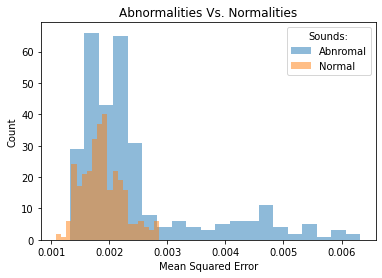

In [26]:
plt.hist(mse_abnormal_list[0:len(mse_list)], label='Abnromal', bins=20, alpha=0.5)
plt.hist(mse_list, label='Normal', bins=20, alpha=0.5)

plt.title('Abnormalities Vs. Normalities')
plt.ylabel('Count')
plt.xlabel('Mean Squared Error')

plt.legend(title='Sounds:')
plt.show()

In [20]:
print('Normal Sounds: \n Mean:{} \n Standar Deviation: {}'.format(np.mean(mse_list), np.std(mse_list)))
print()
print()
print('Abnormal Sounds: \n Mean:{} \n Standar Deviation: {}'.format(np.mean(mse_abnormal_list), np.std(mse_abnormal_list)))

Normal Sounds: 
 Mean:0.0018822305572543064 
 Standar Deviation: 0.0003470571897684953


Abnormal Sounds: 
 Mean:0.0024256051863209235 
 Standar Deviation: 0.0010650671568390516


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


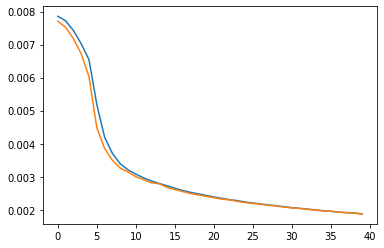

In [21]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [22]:
normal_list = [[mse, 1] for mse in (mse_list[:len(mse_abnormal_list)])]
abnormal_list = [[mse, 0] for mse in np.sort(mse_abnormal_list)]
completed_list = np.concatenate((normal_list, abnormal_list))

df = pd.DataFrame(completed_list)
df = df.sort_values(by=0)
completed_list = df.to_numpy()

In [24]:
metrics.auc(completed_list[:,0], completed_list[:,1]) # Aquí li estic passant errors i no hauria de ser aixi. 
# Crec que li hauria de passar les lineas de distribucio del histograma.

0.0009985911095794276

## Slider 00

In [5]:
normal_path = '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id00/'
anomalies_path = '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id00/'
X_normal = []
X_abnormal = []

for audio in load_files_list(normal_path):
    array = np.load(normal_path + '/' + audio)
    array = array.reshape(16, 27, 128)
    for i in range(128):
        if np.max(array[:,:,i]) != 0:
            array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
    X_normal.append(array)
    
    
for audio in load_files_list(anomalies_path):
    array = np.load(anomalies_path + '/' + audio)
    array = array.reshape(16, 27, 128)
    for i in range(128):
        if np.max(array[:,:,i]) != 0:
            array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
    X_abnormal.append(array)


X_normal = np.asarray(X_normal) # This is to solve a problem with the upscailings.
X_normal = X_normal.reshape(X_normal.shape[0], 1, X_normal.shape[1], X_normal.shape[2], X_normal.shape[3])
Y = np.zeros([X_normal.shape[0], X_normal.shape[1], X_normal.shape[2], X_normal.shape[3] + 1, X_normal.shape[4]])
Y[:,:,:,:-1,:] = X_normal
X_normal = Y

X_abnormal = np.asarray(X_abnormal) # This is to solve a problem with the upscailings.
X_abnormal = X_abnormal.reshape(X_abnormal.shape[0], 1, X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3])
Y = np.zeros([X_abnormal.shape[0], X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3] + 1, X_abnormal.shape[4]])
Y[:,:,:,:-1,:] = X_abnormal
X_abnormal = Y

X_normal = X_normal.reshape(X_normal.shape[0], 16, 28, 128, 1)
X_abnormal = X_abnormal.reshape(X_abnormal.shape[0],16, 28, 128, 1)

X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.3, random_state=5) # Take a look at how it does the splitting.

In [7]:
history = autoencoder.fit(X_normal_train, X_normal_train, batch_size=45, epochs=30, callbacks=callbacks, validation_split=0.15)

Epoch 1/30
15/15 [==============================] - 151s 10s/step - loss: 0.0077 - mae: 0.0218 - val_loss: 0.0069 - val_mae: 0.0199
Epoch 2/30
15/15 [==============================] - 148s 10s/step - loss: 0.0065 - mae: 0.0178 - val_loss: 0.0060 - val_mae: 0.0171
Epoch 3/30
15/15 [==============================] - 128s 9s/step - loss: 0.0057 - mae: 0.0152 - val_loss: 0.0054 - val_mae: 0.0138
Epoch 4/30
15/15 [==============================] - 127s 8s/step - loss: 0.0052 - mae: 0.0138 - val_loss: 0.0051 - val_mae: 0.0132
Epoch 5/30
15/15 [==============================] - 129s 9s/step - loss: 0.0049 - mae: 0.0130 - val_loss: 0.0048 - val_mae: 0.0125
Epoch 6/30
15/15 [==============================] - 127s 8s/step - loss: 0.0047 - mae: 0.0125 - val_loss: 0.0046 - val_mae: 0.0125
Epoch 7/30
15/15 [==============================] - 127s 8s/step - loss: 0.0045 - mae: 0.0120 - val_loss: 0.0044 - val_mae: 0.0116
Epoch 8/30
15/15 [==============================] - 127s 8s/step - loss: 0.0043 -

In [21]:
normal_predictions = autoencoder.predict(X_normal_test)

mse_list = []
mse_abnormal_list = []

for i in range (normal_predictions.shape[0]):
    x_reshaped = X_normal_test[i].reshape(16, 28*128)
    pred_reshaped = normal_predictions[i].reshape(16, 28*128)
    mse_list.append(mse(x_reshaped, pred_reshaped))
    
abnormal_predictions = autoencoder.predict(X_abnormal)

for i in range (abnormal_predictions.shape[0]):
    x_reshaped = X_abnormal[i].reshape(16, 28*128)
    pred_reshaped = abnormal_predictions[i].reshape(16, 28*128)
    mse_abnormal_list.append(mse(x_reshaped, pred_reshaped))

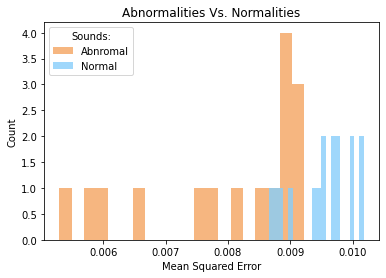

In [16]:
plt.hist(mse_abnormal_list[0:normal_predictions.shape[0]], label='Abnromal', bins=20, alpha=0.8, color='sandybrown')
plt.hist(mse_list, label='Normal', bins=20, alpha=0.8, color='lightskyblue')

plt.title('Abnormalities Vs. Normalities')
plt.ylabel('Count')
plt.xlabel('Mean Squared Error')

plt.legend(title='Sounds:')
plt.show()

In [23]:
print('Normal Sounds: \n Mean:{} \n Standar Deviation: {}'.format(np.mean(mse_list), np.std(mse_list)))
print()
print()
print('Abnormal Sounds: \n Mean:{} \n Standar Deviation: {}'.format(np.mean(mse_abnormal_list), np.std(mse_abnormal_list)))

Normal Sounds: 
 Mean:0.002639099123476162 
 Standar Deviation: 0.0003465755418839057


Abnormal Sounds: 
 Mean:0.003894837385375433 
 Standar Deviation: 0.000508821945498195


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


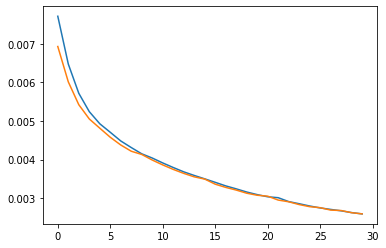

In [24]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [25]:
normal_list = [[mse, 0] for mse in (mse_list[:len(mse_abnormal_list)])]
abnormal_list = [[mse, 1] for mse in np.sort(mse_abnormal_list)]
completed_list = np.concatenate((normal_list, abnormal_list))

df = pd.DataFrame(completed_list)
df = df.sort_values(by=0)
completed_list = df.to_numpy()

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(completed_list[:,1], completed_list[:,0]) # Aquí li estic passant errors i no hauria de ser aixi. 
# Crec que li hauria de passar les lineas de distribucio del histograma.

In [27]:
metrics.auc(fpr, tpr)

0.9821309811333963

## Generalized for 16 machines.

Epoch 1/30
14/14 [==============================] - 117s 8s/step - loss: 0.0075 - mae: 0.0193 - val_loss: 0.0071 - val_mae: 0.0234
Epoch 2/30
14/14 [==============================] - 112s 8s/step - loss: 0.0066 - mae: 0.0170 - val_loss: 0.0061 - val_mae: 0.0171
Epoch 3/30
14/14 [==============================] - 112s 8s/step - loss: 0.0056 - mae: 0.0148 - val_loss: 0.0052 - val_mae: 0.0131
Epoch 4/30
14/14 [==============================] - 113s 8s/step - loss: 0.0050 - mae: 0.0128 - val_loss: 0.0048 - val_mae: 0.0127
Epoch 5/30
14/14 [==============================] - 113s 8s/step - loss: 0.0046 - mae: 0.0121 - val_loss: 0.0045 - val_mae: 0.0118
Epoch 6/30
14/14 [==============================] - 113s 8s/step - loss: 0.0044 - mae: 0.0114 - val_loss: 0.0043 - val_mae: 0.0107
Epoch 7/30
14/14 [==============================] - 113s 8s/step - loss: 0.0041 - mae: 0.0108 - val_loss: 0.0041 - val_mae: 0.0108
Epoch 8/30
14/14 [==============================] - 120s 9s/step - loss: 0.0040 - m

14/14 [==============================] - 113s 8s/step - loss: 0.0057 - mae: 0.0158 - val_loss: 0.0055 - val_mae: 0.0155
Epoch 6/30
14/14 [==============================] - 113s 8s/step - loss: 0.0054 - mae: 0.0152 - val_loss: 0.0052 - val_mae: 0.0146
Epoch 7/30
14/14 [==============================] - 114s 8s/step - loss: 0.0051 - mae: 0.0147 - val_loss: 0.0050 - val_mae: 0.0143
Epoch 8/30
14/14 [==============================] - 114s 8s/step - loss: 0.0050 - mae: 0.0143 - val_loss: 0.0049 - val_mae: 0.0136
Epoch 9/30
14/14 [==============================] - 114s 8s/step - loss: 0.0048 - mae: 0.0139 - val_loss: 0.0047 - val_mae: 0.0135
Epoch 10/30
14/14 [==============================] - 114s 8s/step - loss: 0.0046 - mae: 0.0135 - val_loss: 0.0045 - val_mae: 0.0132
Epoch 11/30
14/14 [==============================] - 114s 8s/step - loss: 0.0045 - mae: 0.0132 - val_loss: 0.0044 - val_mae: 0.0135
Epoch 12/30
14/14 [==============================] - 114s 8s/step - loss: 0.0044 - mae: 0.01

15/15 [==============================] - 118s 8s/step - loss: 0.0067 - mae: 0.0205 - val_loss: 0.0062 - val_mae: 0.0181
Epoch 4/30
15/15 [==============================] - 118s 8s/step - loss: 0.0059 - mae: 0.0170 - val_loss: 0.0054 - val_mae: 0.0143
Epoch 5/30
15/15 [==============================] - 118s 8s/step - loss: 0.0052 - mae: 0.0145 - val_loss: 0.0049 - val_mae: 0.0136
Epoch 6/30
15/15 [==============================] - 119s 8s/step - loss: 0.0049 - mae: 0.0134 - val_loss: 0.0047 - val_mae: 0.0135
Epoch 7/30
15/15 [==============================] - 118s 8s/step - loss: 0.0046 - mae: 0.0128 - val_loss: 0.0045 - val_mae: 0.0121
Epoch 8/30
15/15 [==============================] - 118s 8s/step - loss: 0.0044 - mae: 0.0121 - val_loss: 0.0043 - val_mae: 0.0115
Epoch 9/30
15/15 [==============================] - 118s 8s/step - loss: 0.0042 - mae: 0.0117 - val_loss: 0.0041 - val_mae: 0.0118
Epoch 10/30
15/15 [==============================] - 118s 8s/step - loss: 0.0041 - mae: 0.0113

<ipython-input-3-f9b646f34847>:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(dpi=150)


Epoch 1/30
8/8 [==============================] - 54s 7s/step - loss: 0.0086 - mae: 0.0215 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 2/30
8/8 [==============================] - 54s 7s/step - loss: 0.0083 - mae: 0.0145 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 3/30
8/8 [==============================] - 54s 7s/step - loss: 0.0083 - mae: 0.0145 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 4/30
8/8 [==============================] - 54s 7s/step - loss: 0.0083 - mae: 0.0145 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 5/30
8/8 [==============================] - 54s 7s/step - loss: 0.0083 - mae: 0.0145 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 6/30
8/8 [==============================] - 54s 7s/step - loss: 0.0083 - mae: 0.0145 - val_loss: 0.0081 - val_mae: 0.0142
Epoch 00006: early stopping
Epoch 1/30
14/14 [==============================] - 110s 8s/step - loss: 0.0083 - mae: 0.0257 - val_loss: 0.0081 - val_mae: 0.0242
Epoch 2/30
14/14 [==============================] - 109s 8s/step - loss: 

14/14 [==============================] - 109s 8s/step - loss: 0.0038 - mae: 0.0117 - val_loss: 0.0037 - val_mae: 0.0119
Epoch 30/30
14/14 [==============================] - 109s 8s/step - loss: 0.0037 - mae: 0.0116 - val_loss: 0.0037 - val_mae: 0.0112


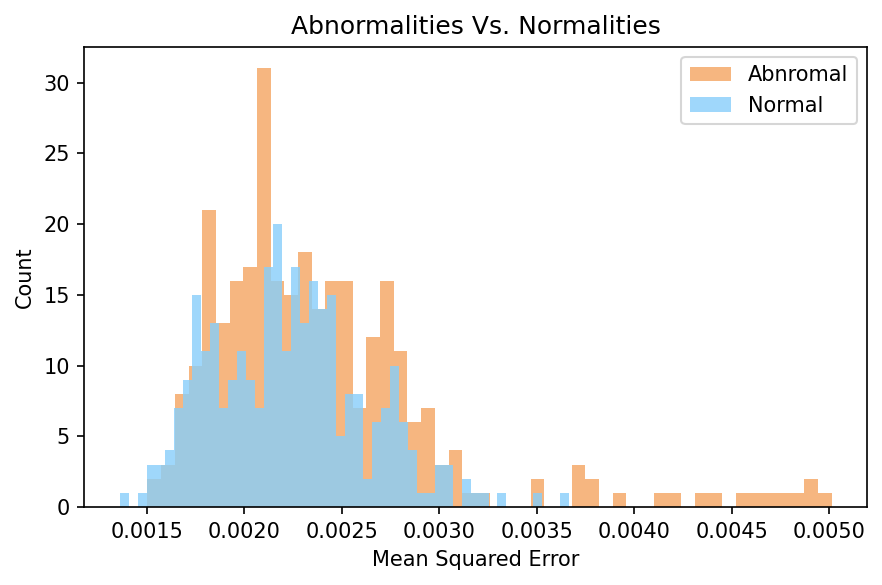

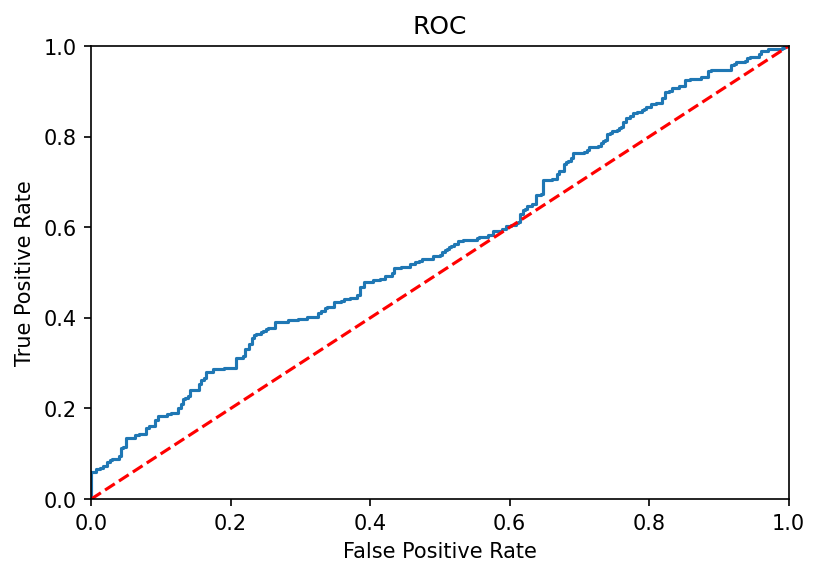

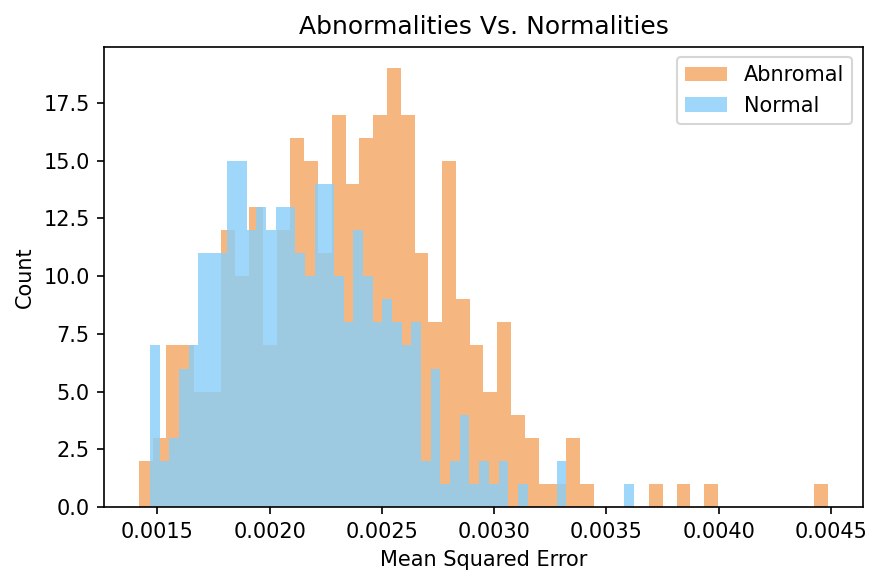

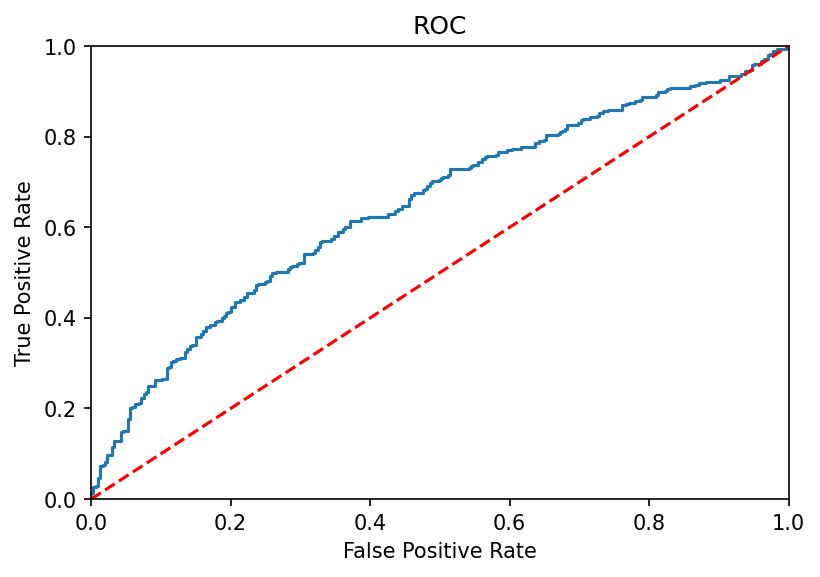

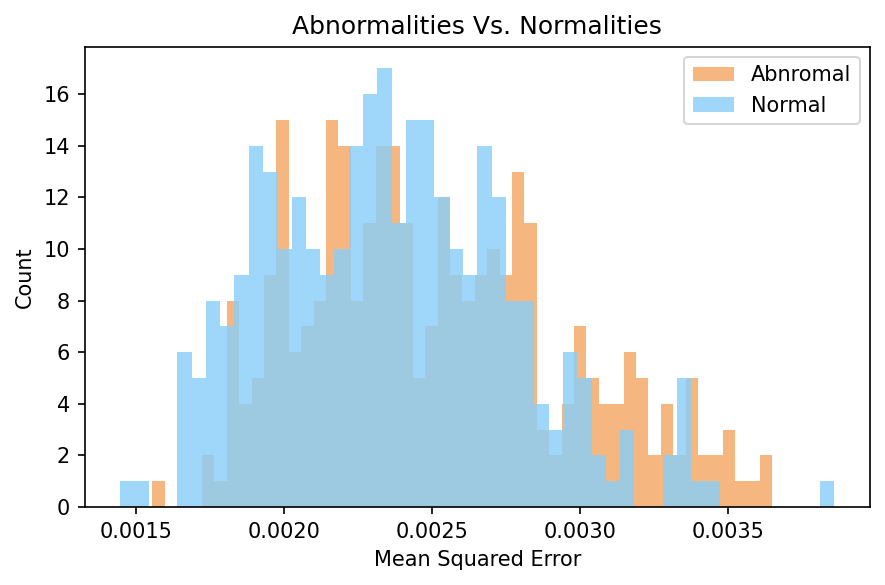

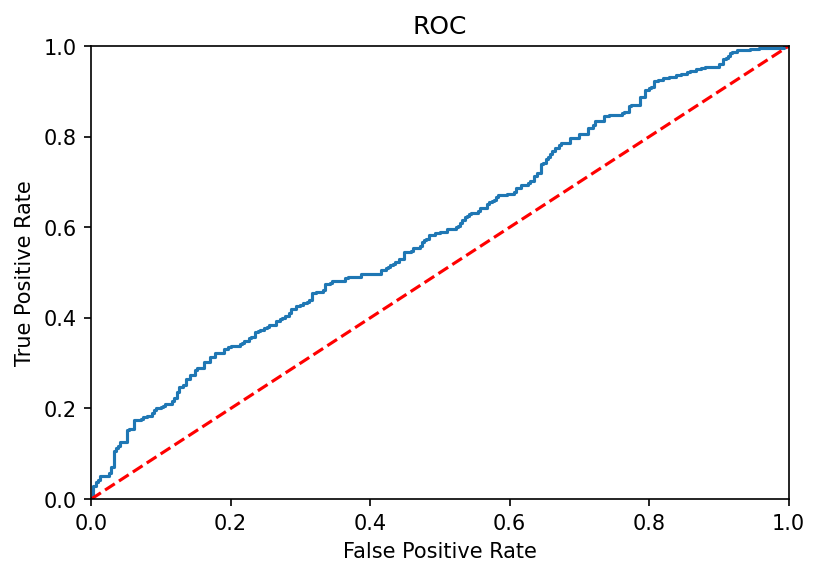

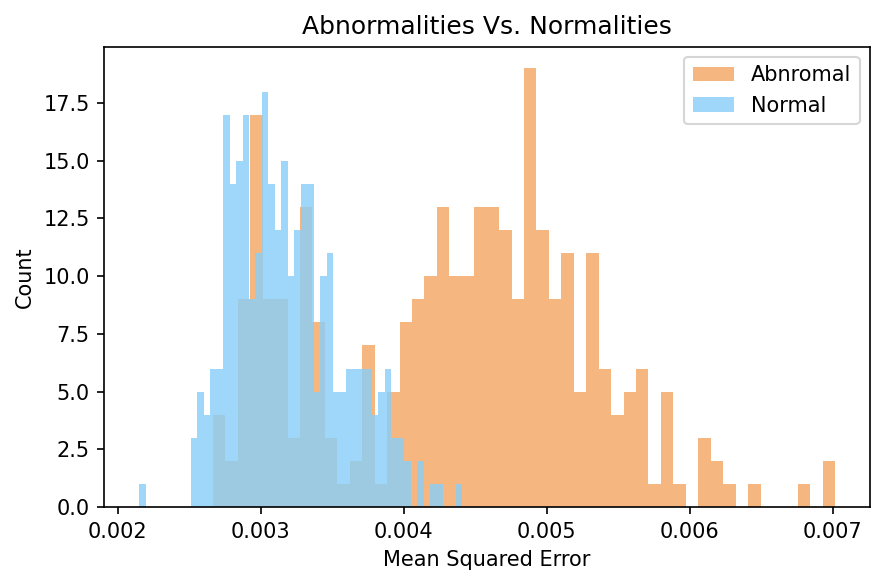

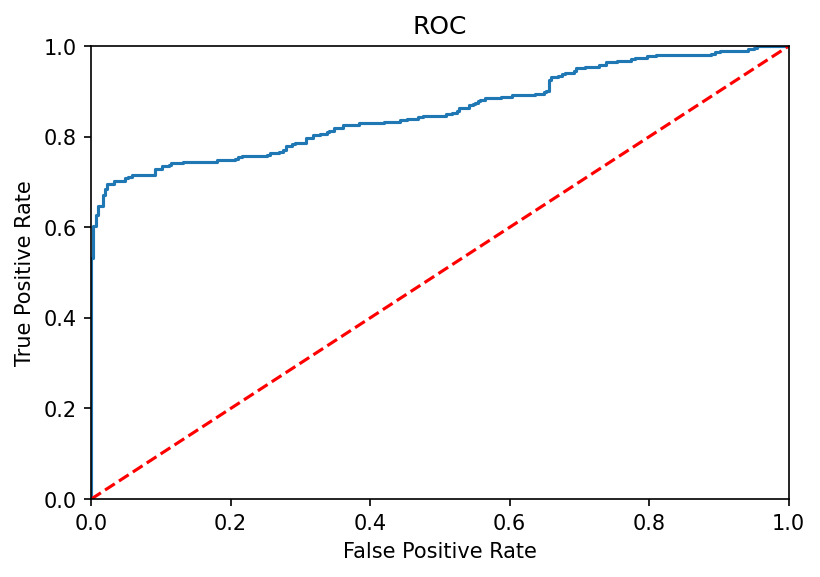

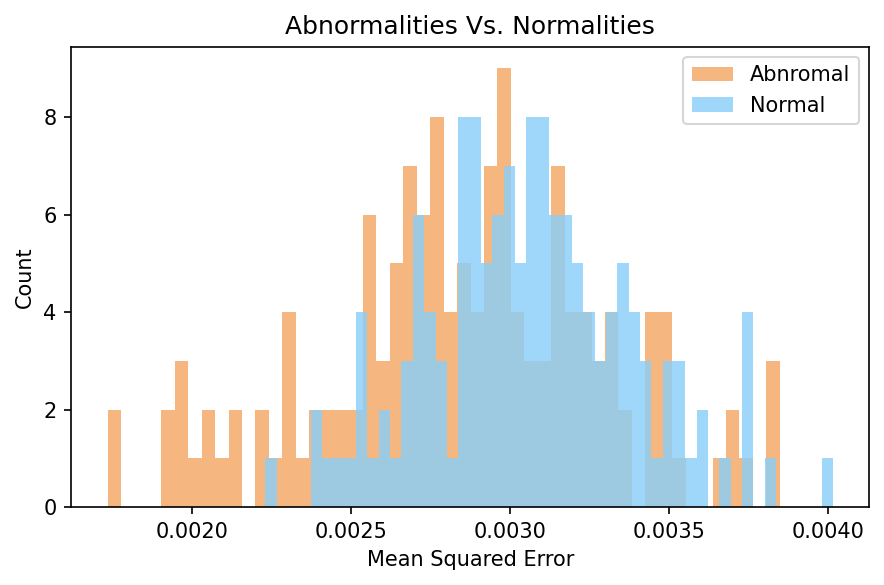

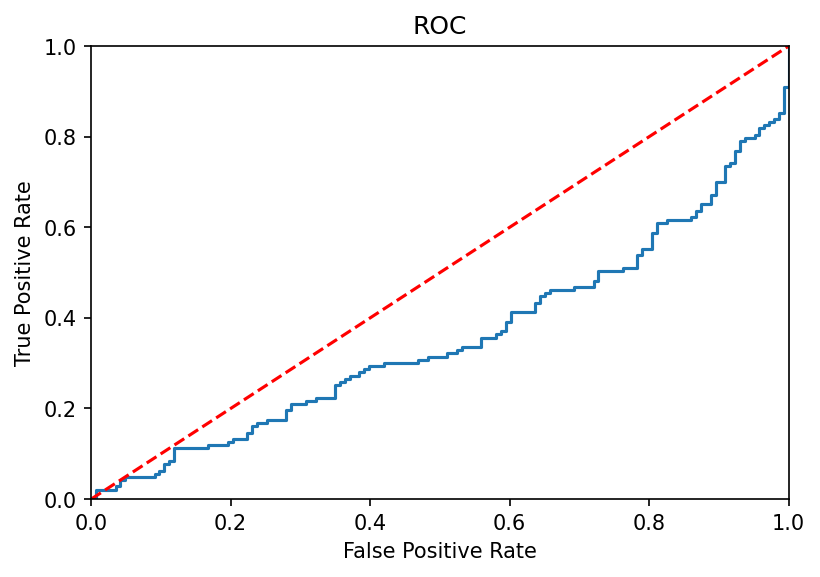

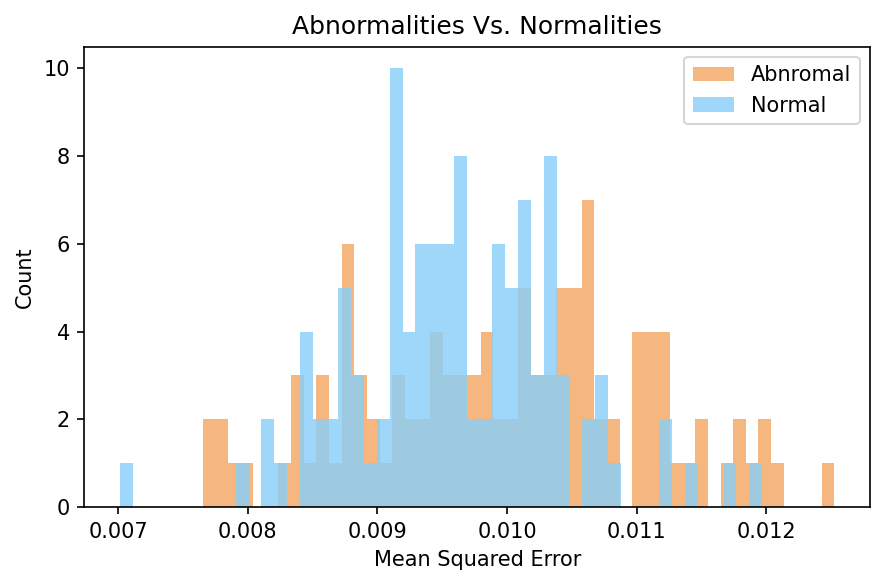

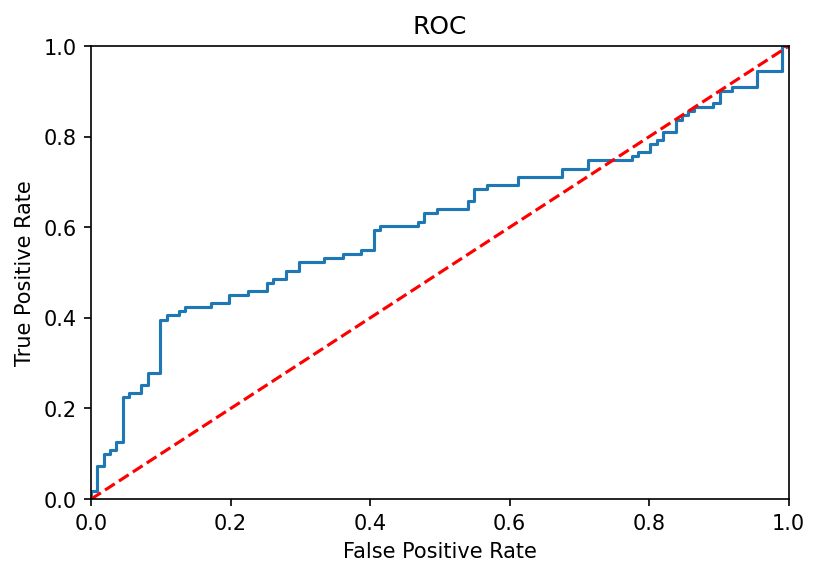

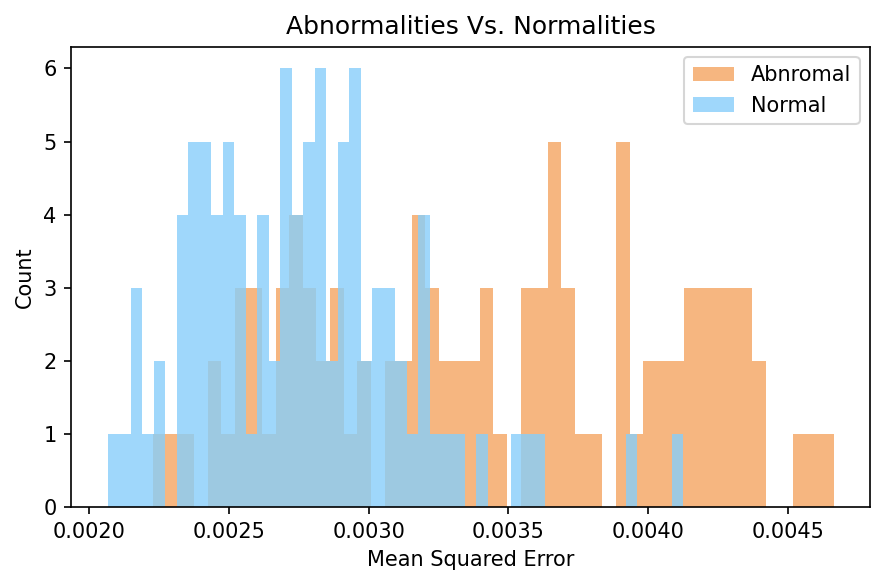

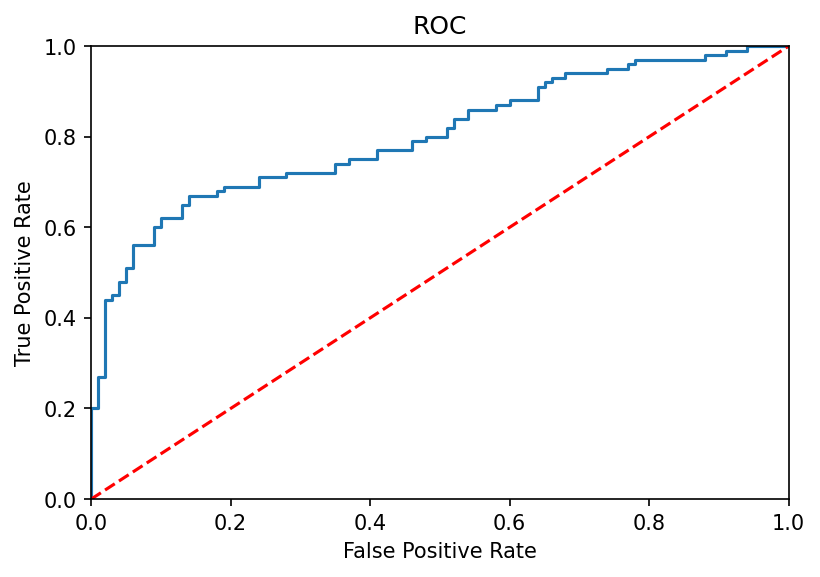

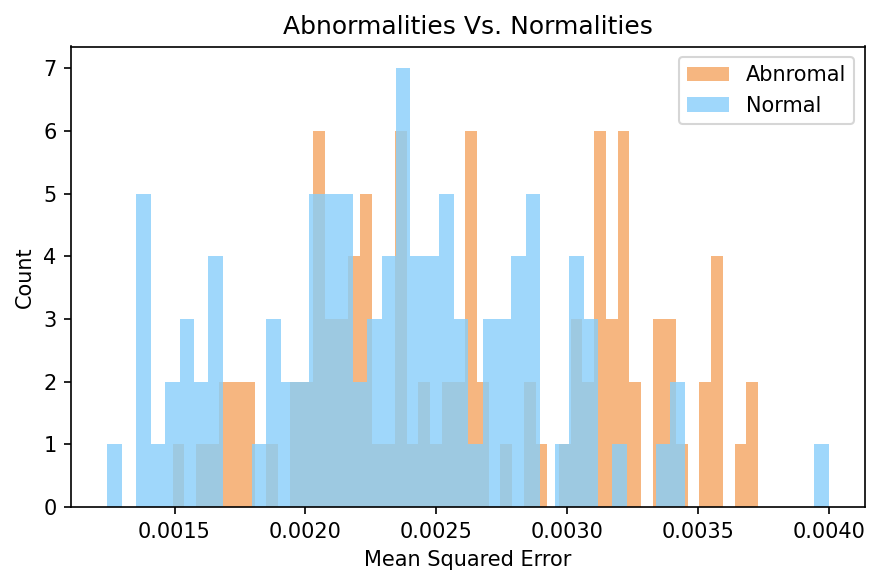

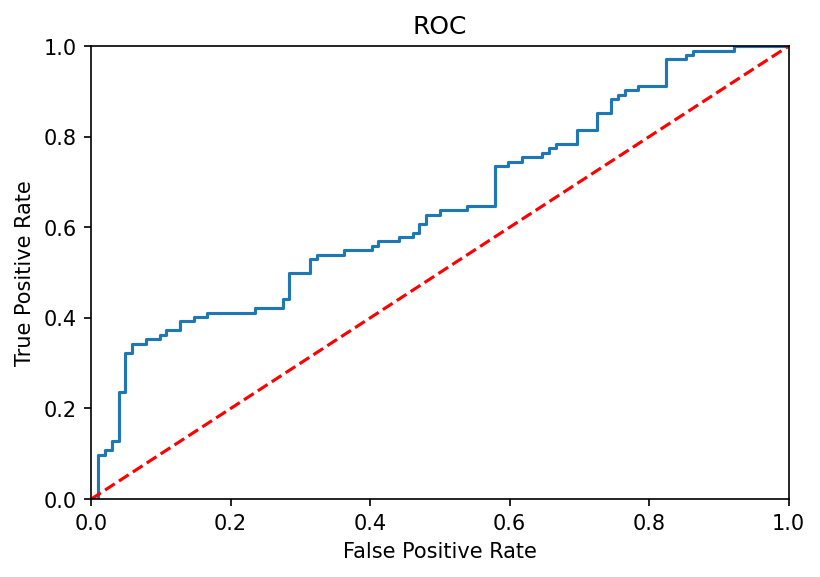

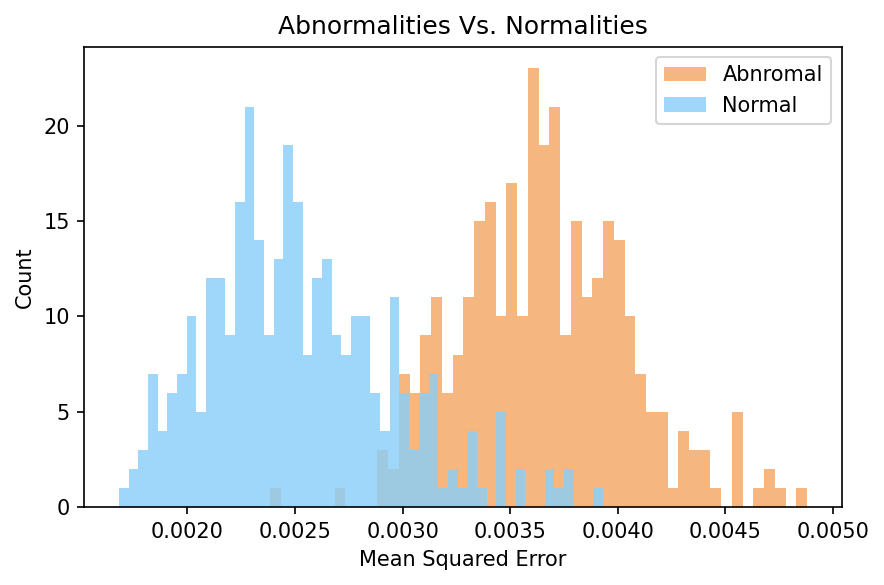

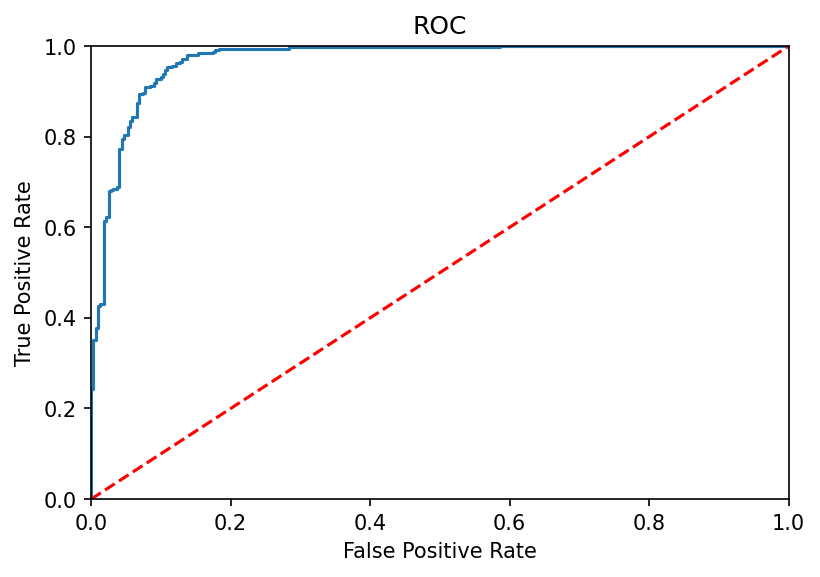

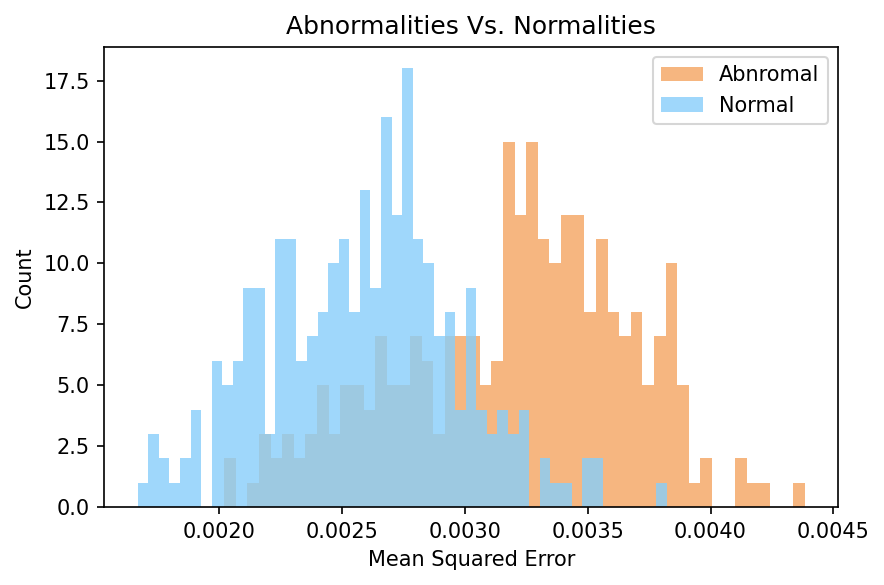

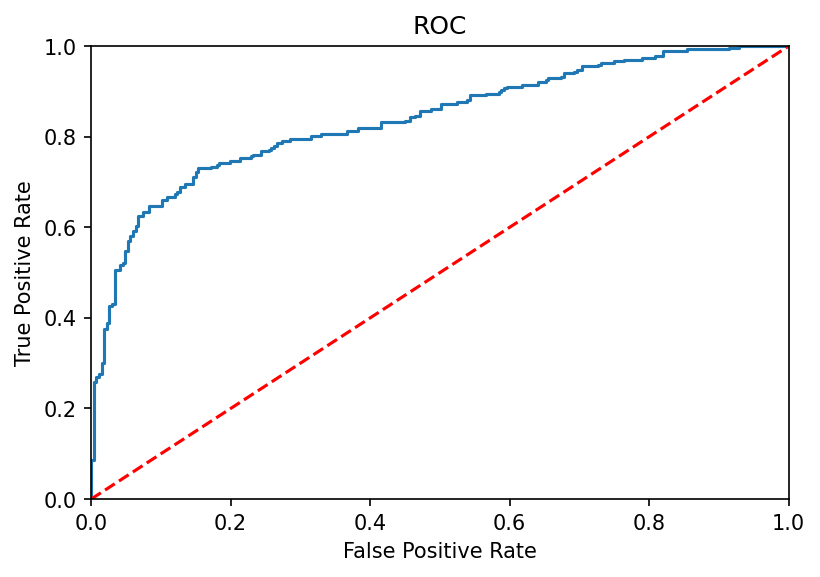

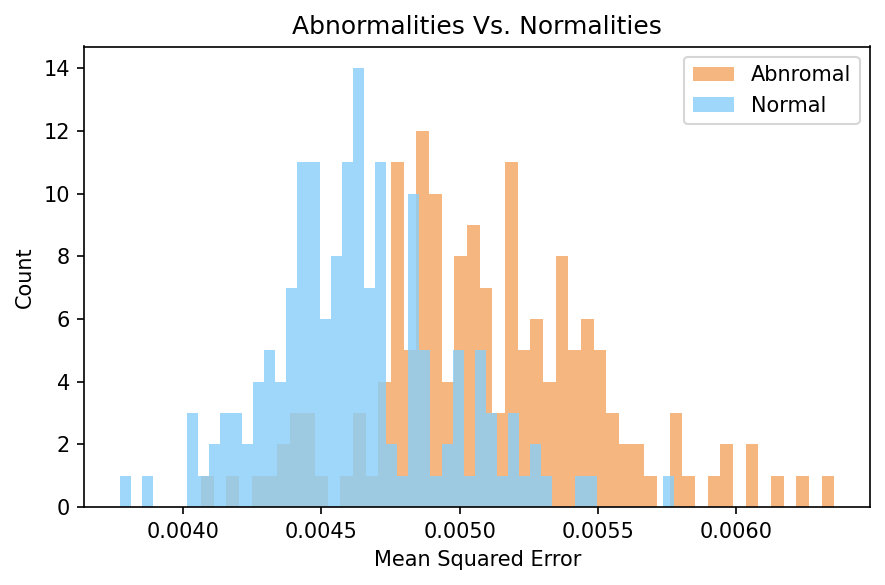

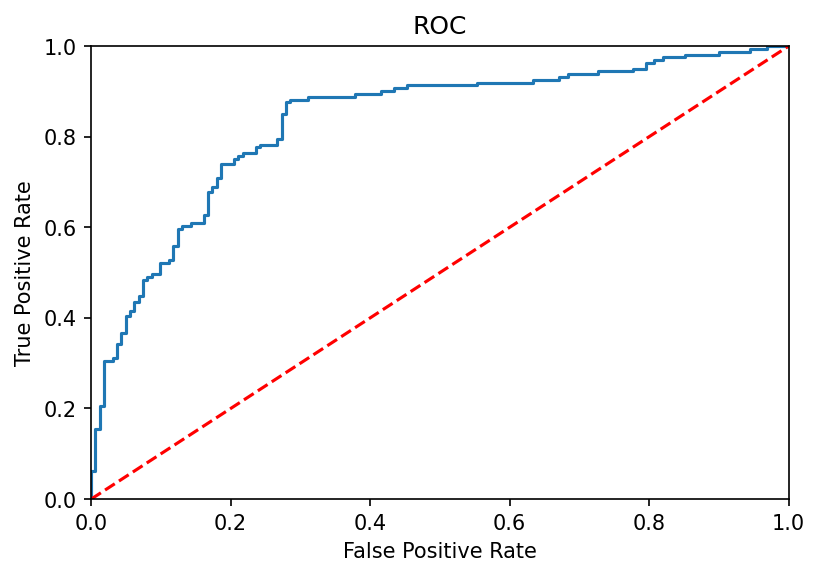

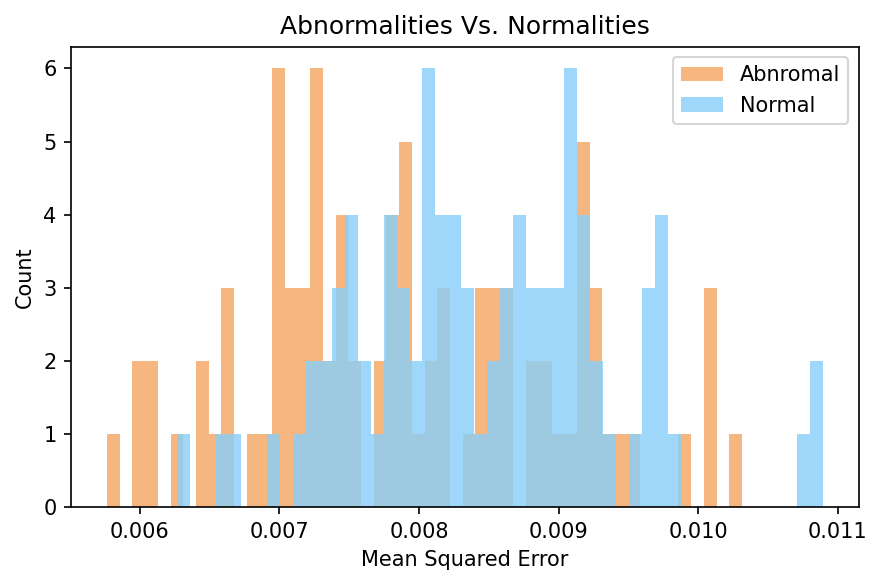

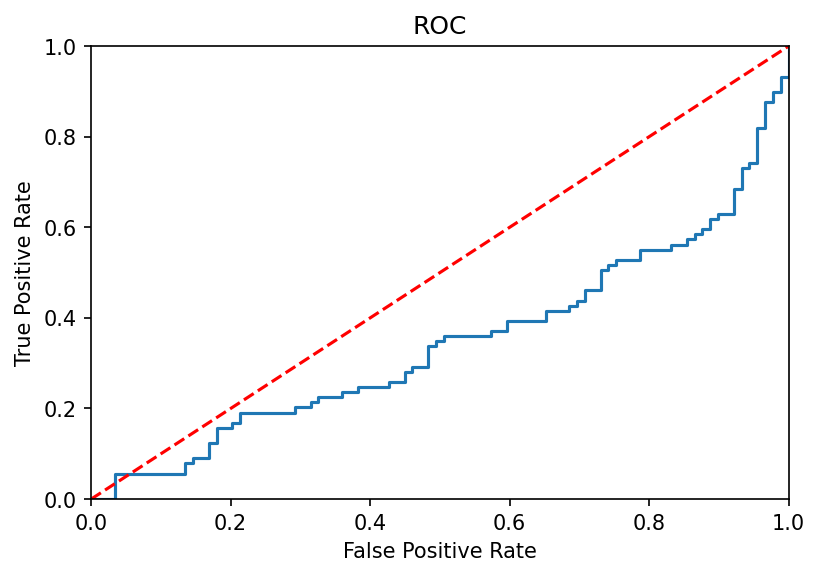

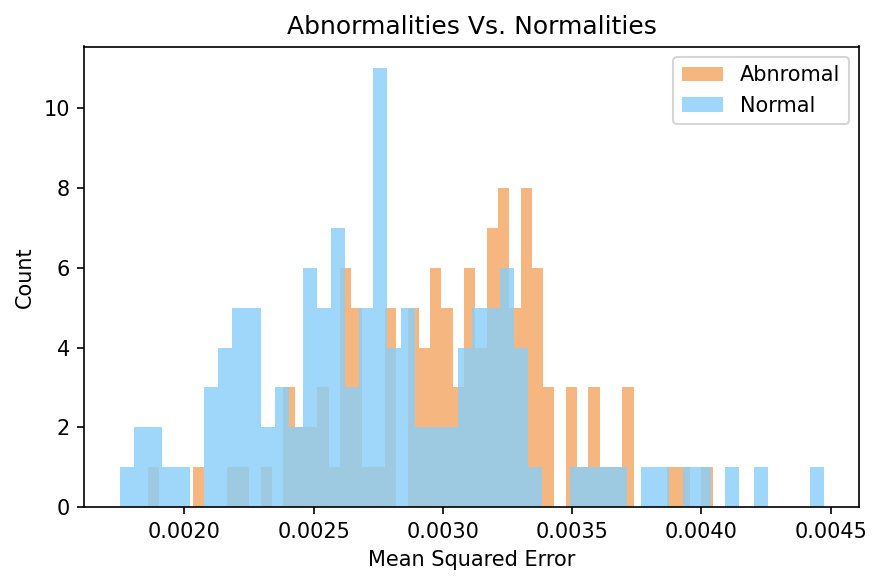

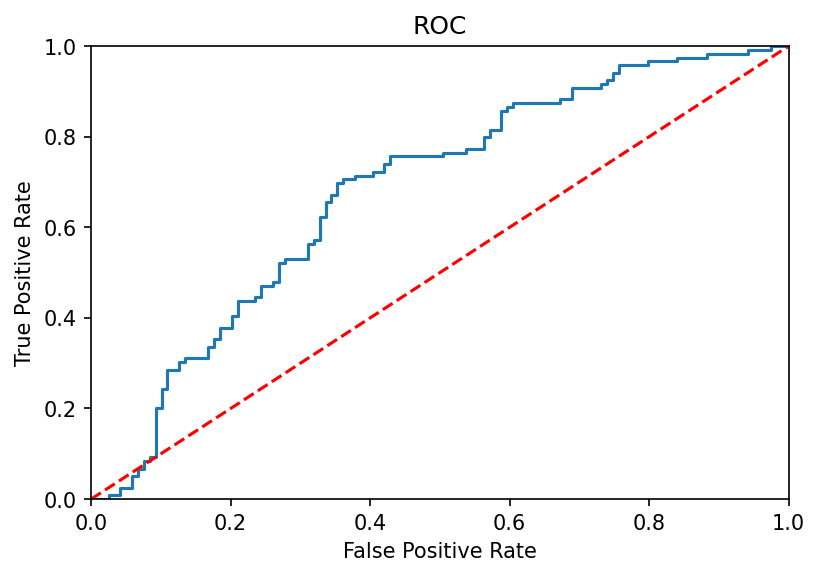

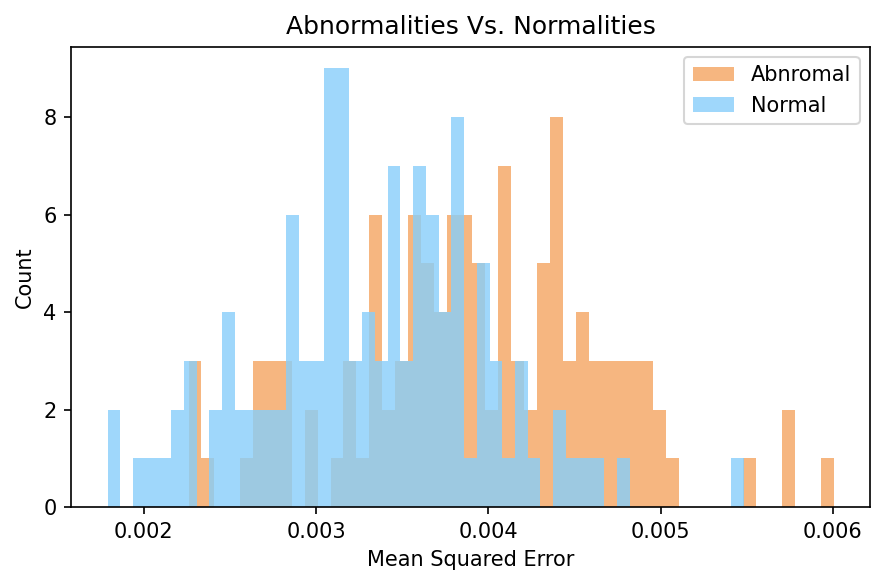

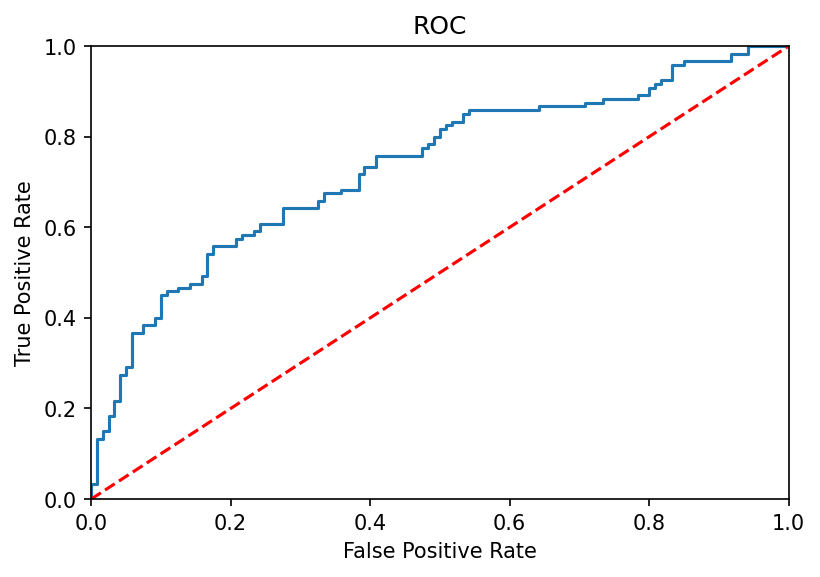

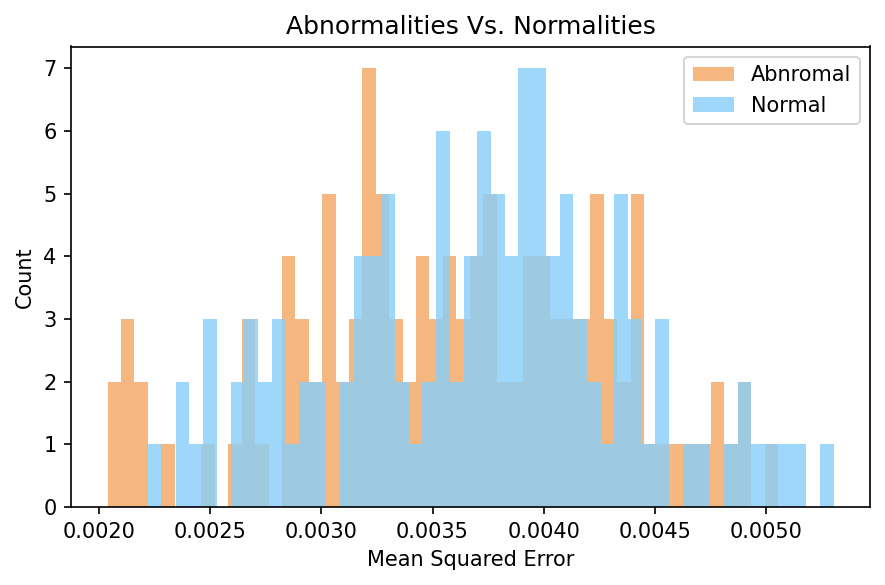

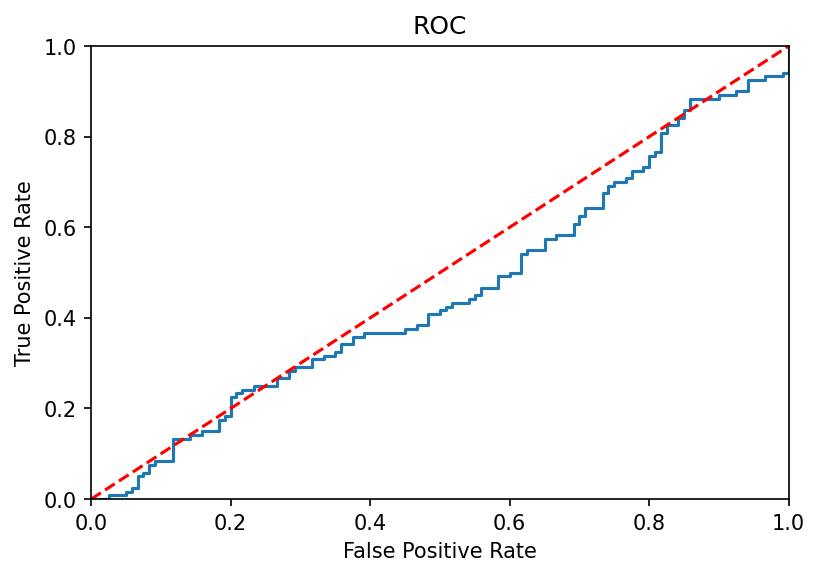

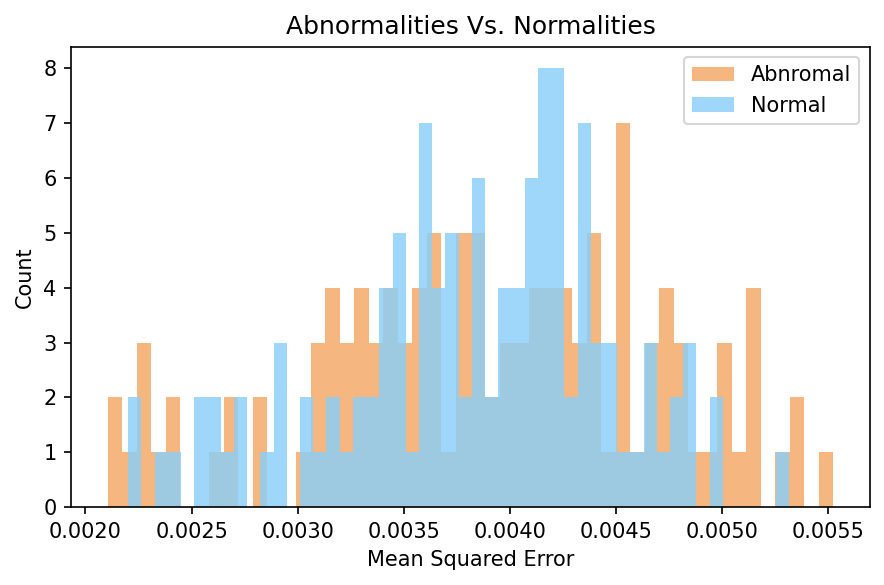

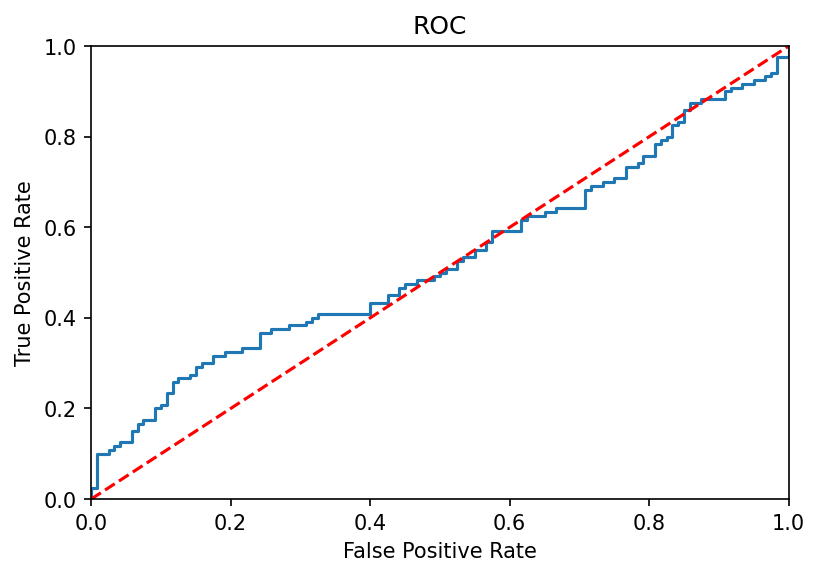

In [3]:
# TROBAR LA MANERA DE PILLAR TOTS ELS AUDIOS. CREAR LLISTA DE RESULTATS I COMENÇAR UN BUCLE
normal_paths = ['../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id00/', '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id04/', '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id06/',
               '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id00/', '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id04/', '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id06/',
               '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id00/', '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id04/', '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id06/',
               '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id00/', '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id04/', '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id06/']


abnormal_paths = ['../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id02/',
               '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id06/',
               '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id02/',
               '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id06/',
               '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id02/',
               '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id06/',
               '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id02/',
               '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id04/'] 


resultats = []
    
for normal_path, anomalies_path in zip(normal_paths, abnormal_paths):


    X_normal = []
    X_abnormal = []

    for audio in load_files_list(normal_path):
        array = np.load(normal_path + '/' + audio)
        array = array.reshape(16, 27, 128)
        for i in range(128):
            if np.max(array[:,:,i]) != 0:
                array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
        X_normal.append(array)
    
    
    for audio in load_files_list(anomalies_path):
        array = np.load(anomalies_path + '/' + audio)
        array = array.reshape(16, 27, 128)
        for i in range(128):
            if np.max(array[:,:,i]) != 0:
                array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
        X_abnormal.append(array)


    X_normal = np.asarray(X_normal) # This is to solve a problem with the upscailings.
    X_normal = X_normal.reshape(X_normal.shape[0], 1, X_normal.shape[1], X_normal.shape[2], X_normal.shape[3])
    Y = np.zeros([X_normal.shape[0], X_normal.shape[1], X_normal.shape[2], X_normal.shape[3] + 1, X_normal.shape[4]])
    Y[:,:,:,:-1,:] = X_normal
    X_normal = Y

    X_abnormal = np.asarray(X_abnormal) # This is to solve a problem with the upscailings.
    X_abnormal = X_abnormal.reshape(X_abnormal.shape[0], 1, X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3])
    Y = np.zeros([X_abnormal.shape[0], X_abnormal.shape[1], X_abnormal.shape[2], X_abnormal.shape[3] + 1, X_abnormal.shape[4]])
    Y[:,:,:,:-1,:] = X_abnormal
    X_abnormal = Y

    X_normal = X_normal.reshape(X_normal.shape[0], 16, 28, 128, 1)
    X_abnormal = X_abnormal.reshape(X_abnormal.shape[0],16, 28, 128, 1)

    X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.3, random_state=5) # Take a look at how it does the splitting.


# AUTOENCODER
    autoencoder = Sequential()

    autoencoder.add(Conv3D(8, (3,3,3), activation='relu', padding='same', input_shape=(16,28,128, 1))) 
    autoencoder.add(MaxPool3D(pool_size=(2,2,2)))
    autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
    autoencoder.add(MaxPool3D(pool_size=(2,2,2)))

    autoencoder.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))

    autoencoder.add(UpSampling3D(size=2))
    autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D(size=2))
    autoencoder.add(Conv3D(8,(3,3,3), activation='relu', padding='same'))

    autoencoder.add(Conv3D(1,(3,3,3), activation='relu', padding='same'))

    opt = keras.optimizers.Adam(learning_rate=0.001)


    autoencoder.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')]


# TRAINING
    history = autoencoder.fit(X_normal_train, X_normal_train, batch_size=45, epochs=30, callbacks=callbacks, validation_split=0.15)

# MINIMUM VALUE

    minimum_value = min(X_normal_test.shape[0], X_abnormal.shape[0])


    normal_predictions = autoencoder.predict(X_normal_test[0:minimum_value])

# ERRORS
    
    mse_list = []
    mse_abnormal_list = []

    # ERRORS DE RECONSTRUCCIÓ EN SONS REALS
    for i in range (normal_predictions.shape[0]):
        x_reshaped = X_normal_test[i].reshape(16, 28*128)
        pred_reshaped = normal_predictions[i].reshape(16, 28*128)
        mse_list.append(mse(x_reshaped, pred_reshaped))
    
    abnormal_predictions = autoencoder.predict(X_abnormal[0:minimum_value])

    # ERRORS DE RECONSTRUCCIÓ EN ANOMALIES
    for i in range (abnormal_predictions.shape[0]):
        x_reshaped = X_abnormal[i].reshape(16, 28*128)
        pred_reshaped = abnormal_predictions[i].reshape(16, 28*128)
        mse_abnormal_list.append(mse(x_reshaped, pred_reshaped))
        
        
# IDENTIFICATION

    identificacio = normal_path.split('/')[-2].split('_id')

# HISTOGRAMS

    fig = plt.figure(dpi=150)
    plt.hist(mse_abnormal_list, label='Abnromal', bins=50, alpha=0.8, color='sandybrown')
    plt.hist(mse_list, label='Normal', bins=50, alpha=0.8, color='lightskyblue')

    plt.xlabel('input')
    plt.ylabel('output')
    plt.title('Abnormalities Vs. Normalities')
    plt.ylabel('Count')
    plt.xlabel('Mean Squared Error')

    plt.legend(title='Sounds:')
    plt.legend()
    fig.tight_layout()
    fig.savefig('/home/toni_domenech/s_a_d_histos/' + identificacio[0] + identificacio[1] +'.png', dpi=200) 
        
        
    


# MÈTODE PER A CALCULAR LES AUC
    normal_list = [[mse, 0] for mse in (mse_list[:len(mse_abnormal_list)])] 
    abnormal_list = [[mse, 1] for mse in np.sort(mse_abnormal_list)] 
    completed_list = np.concatenate((normal_list, abnormal_list))

    df = pd.DataFrame(completed_list)
    df = df.sort_values(by=0)
    completed_list = df.to_numpy()

    
    fpr, tpr, thresholds = metrics.roc_curve(completed_list[:,1], completed_list[:,0]) 
    
    
# ROC CURVE 

    fig = plt.figure(dpi=150)
    plt.title('ROC')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    fig.savefig('/home/toni_domenech/roc/' + identificacio[0] + identificacio[1] +'.png', dpi=200) 



# RESULTS    
    puntuacio = metrics.auc(fpr, tpr)
    
    
    resultats.append(identificacio[0])
    resultats.append(identificacio[1])
    resultats.append(puntuacio)

# AFEGIR ELS VALORS A LA LLISTA GENERAL I UNA ETIQUETA PER A SABER QUINA MÀQUINA ÉS QUINA

In [5]:
resultats = np.asarray(resultats)

In [10]:
np.save('results.npy',arr=resultats)

## Generalize for 4 machines.

In [3]:
# TROBAR LA MANERA DE PILLAR TOTS ELS AUDIOS. CREAR LLISTA DE RESULTATS I COMENÇAR UN BUCLE

normal_fan = ['../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id00/', '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id04/', '../Datasets/s_a_d__datasets/3D_descripted/fan/fan_id06/']

abnormal_fan = ['../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id02/',
               '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/fan/abnormal_id06/']

normal_pump = ['../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id00/', '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id02/',
               '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id04/', '../Datasets/s_a_d__datasets/3D_descripted/pump/pump_id06/']

normal_slider = ['../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id00/', '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id02/',
                 '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id04/', '../Datasets/s_a_d__datasets/3D_descripted/slider/slider_id06/']

normal_valve = ['../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id00/', '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id02/',
                '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id04/', '../Datasets/s_a_d__datasets/3D_descripted/valve/valve_id06/']

               
abnormal_pump = ['../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id02/',
                 '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/pump/abnormal_id06/']
abnormal_slider = ['../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id02/',
                   '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/slider/abnormal_id06/']
abnormal_valve = ['../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id00/', '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id02/',
                  '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id04/', '../Datasets/s_a_d__datasets/abnormal_3D/valve/abnormal_id06/']
resultats = []



normal_machines = [normal_fan, normal_pump, normal_slider, normal_valve]
abnormal_machines = [abnormal_fan, abnormal_pump, abnormal_slider, abnormal_valve]



for normal_machine, abnormal_machine in zip(normal_machines, abnormal_machines):
    X_normal = []
    X_train = []
    test_00 = []
    test_02 = []
    test_04 = []
    test_06 = []

    X_abnormal_00 = []
    X_abnormal_02 = []
    X_abnormal_04 = []
    X_abnormal_06 = []
    
    test_list = [test_00, test_02, test_04, test_06]
    abnormal_list = [X_abnormal_00, X_abnormal_02, X_abnormal_04, X_abnormal_06]


    for normal_path, anomalies_path, test_id, abnormal_id in zip(normal_machine, abnormal_machine, test_list, abnormal_list):

    
        X_normal = []
        for audio in load_files_list(normal_path):
            array = np.load(normal_path + '/' + audio)
            array = array.reshape(16, 27, 128)
        # Normalizing an array
            for i in range(128):
                if np.max(array[:,:,i]) != 0:
                    array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
            X_normal.append(array)

        
        X_normal = np.asarray(X_normal) # This is to solve a problem with the upscailings.
        X_normal = X_normal.reshape(X_normal.shape[0], 1, X_normal.shape[1], X_normal.shape[2], X_normal.shape[3])
        Y = np.zeros([X_normal.shape[0], X_normal.shape[1], X_normal.shape[2], X_normal.shape[3] + 1, X_normal.shape[4]])
        Y[:,:,:,:-1,:] = X_normal
        X_normal = Y
    
    # Reshaping to train it normaly
        X_normal = X_normal.reshape(X_normal.shape[0], 16, 28, 128, 1)

    # Splitting. Saving normal sounds for each id separately.
        X_normal_train, test_id = train_test_split(X_normal, test_size=0.3, random_state=5) # Take a look at how it does the splitting.

    # We are going to train with all the data so we charge it here.
        X_train.append(X_normal_train)
    
        for audio in load_files_list(anomalies_path):
            array = np.load(anomalies_path + '/' + audio)
            array = array.reshape(16, 27, 128)
            for i in range(128):
                if np.max(array[:,:,i]) != 0:
                    array[:,:,i] = (array[:,:,i]-np.min(array[:,:,i]))/(np.max(array[:,:,i])-np.min(array[:,:,i]))
            abnormal_id.append(array)




        abnormal_id = np.asarray(abnormal_id) # This is to solve a problem with the upscailings.
        abnormal_id = abnormal_id.reshape(abnormal_id.shape[0], 1, abnormal_id.shape[1], abnormal_id.shape[2], abnormal_id.shape[3])
        Y = np.zeros([abnormal_id.shape[0], abnormal_id.shape[1], abnormal_id.shape[2], abnormal_id.shape[3] + 1, abnormal_id.shape[4]])
        Y[:,:,:,:-1,:] = abnormal_id
        abnormal_id = Y

        abnormal_id = abnormal_id.reshape(abnormal_id.shape[0],16, 28, 128, 1)



# AUTOENCODER
    autoencoder = Sequential()

    autoencoder.add(Conv3D(8, (3,3,3), activation='relu', padding='same', input_shape=(16,28,128, 1))) 
    autoencoder.add(MaxPool3D(pool_size=(2,2,2)))
    autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
    autoencoder.add(MaxPool3D(pool_size=(2,2,2)))
    
    autoencoder.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
    
    autoencoder.add(UpSampling3D(size=2))
    autoencoder.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D(size=2))
    autoencoder.add(Conv3D(8,(3,3,3), activation='relu', padding='same'))
    
    autoencoder.add(Conv3D(1,(3,3,3), activation='relu', padding='same'))

    opt = keras.optimizers.Adam(learning_rate=0.001)


    autoencoder.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')]


# TRAINING
    history = autoencoder.fit(X_normal_train, X_normal_train, batch_size=45, epochs=30, callbacks=callbacks, validation_split=0.15)


# EVALUATION


    for X_normal_test, X_abnormal in zip(test_list, abnormal_list):
# MINIMUM VALUE

        X_normal_test = np.asarray(X_normal_test)
        X_abnormal = np.asarray(X_abnormal)

        minimum_value = min(X_normal_test.shape[0], X_abnormal.shape[0])


        normal_predictions = autoencoder.predict(X_normal_test[0:minimum_value])

# ERRORS
    
        mse_list = []
        mse_abnormal_list = []

    # ERRORS DE RECONSTRUCCIÓ EN SONS REALS
        for i in range (normal_predictions.shape[0]):
            x_reshaped = X_normal_test[i].reshape(16, 28*128)
            pred_reshaped = normal_predictions[i].reshape(16, 28*128)
            mse_list.append(mse(x_reshaped, pred_reshaped))
    
        abnormal_predictions = autoencoder.predict(X_abnormal[0:minimum_value])

    # ERRORS DE RECONSTRUCCIÓ EN ANOMALIES
        for i in range (abnormal_predictions.shape[0]):
            x_reshaped = X_abnormal[i].reshape(16, 28*128)
            pred_reshaped = abnormal_predictions[i].reshape(16, 28*128)
            mse_abnormal_list.append(mse(x_reshaped, pred_reshaped))
        
        
# IDENTIFICATION

        identificacio = normal_path.split('/')[-2].split('_id')

# HISTOGRAMS

        fig = plt.figure(dpi=150)
        plt.hist(mse_abnormal_list, label='Abnromal', bins=50, alpha=0.8, color='sandybrown')
        plt.hist(mse_list, label='Normal', bins=50, alpha=0.8, color='lightskyblue')
    
        plt.xlabel('input')
        plt.ylabel('output')
        plt.title('Abnormalities Vs. Normalities')
        plt.ylabel('Count')
        plt.xlabel('Mean Squared Error')

        plt.legend(title='Sounds:')
        plt.legend()
        fig.tight_layout()
        fig.savefig('/home/toni_domenech/s_a_d_histos/' + identificacio[0] + identificacio[1] +'.png', dpi=200) 
        
        
    


# MÈTODE PER A CALCULAR LES AUC
        normal_list = [[mse, 0] for mse in (mse_list[:len(mse_abnormal_list)])] 
        abnormal_list = [[mse, 1] for mse in np.sort(mse_abnormal_list)] 
        completed_list = np.concatenate((normal_list, abnormal_list))
    
        df = pd.DataFrame(completed_list)
        df = df.sort_values(by=0)
        completed_list = df.to_numpy()

    
        fpr, tpr, thresholds = metrics.roc_curve(completed_list[:,1], completed_list[:,0]) 
    
    
# ROC CURVE 

        fig = plt.figure(dpi=150)
        plt.title('ROC')
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        fig.savefig('/home/toni_domenech/roc/' + identificacio[0] + identificacio[1] + '.png', dpi=200) 



# RESULTS    
        puntuacio = metrics.auc(fpr, tpr)
    
    
        resultats.append(identificacio[0])
        resultats.append(identificacio[1])
        resultats.append(puntuacio)
    


# AFEGIR ELS VALORS A LA LLISTA GENERAL I UNA ETIQUETA PER A SABER QUINA MÀQUINA ÉS QUINA

Epoch 1/30
14/14 [==============================] - 115s 8s/step - loss: 0.0090 - mae: 0.0207 - val_loss: 0.0081 - val_mae: 0.0225
Epoch 2/30
14/14 [==============================] - 113s 8s/step - loss: 0.0076 - mae: 0.0204 - val_loss: 0.0065 - val_mae: 0.0182
Epoch 3/30
14/14 [==============================] - 114s 8s/step - loss: 0.0058 - mae: 0.0153 - val_loss: 0.0046 - val_mae: 0.0123
Epoch 4/30
14/14 [==============================] - 114s 8s/step - loss: 0.0042 - mae: 0.0110 - val_loss: 0.0037 - val_mae: 0.0099
Epoch 5/30
14/14 [==============================] - 114s 8s/step - loss: 0.0036 - mae: 0.0093 - val_loss: 0.0033 - val_mae: 0.0086
Epoch 6/30
14/14 [==============================] - 114s 8s/step - loss: 0.0033 - mae: 0.0086 - val_loss: 0.0031 - val_mae: 0.0083
Epoch 7/30
14/14 [==============================] - 114s 8s/step - loss: 0.0031 - mae: 0.0083 - val_loss: 0.0029 - val_mae: 0.0079
Epoch 8/30
14/14 [==============================] - 114s 8s/step - loss: 0.0029 - m

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [8]:
test_id

(305, 16, 28, 128, 1)

## ROC & AUC

In [11]:
from sklearn import metrics

In [12]:
normal_list = [[mse, 1] for mse in (mse_list[:len(mse_abnormal_list)])]
abnormal_list = [[mse, 0] for mse in np.sort(mse_abnormal_list)]
completed_list = np.concatenate((normal_list, abnormal_list))

df = pd.DataFrame(completed_list)
df = df.sort_values(by=0)
completed_list = df.to_numpy()

NameError: name 'mse_list' is not defined

In [13]:
plt.hist(mse_abnormal_list[0:normal_predictions.shape[0]], label='Abnromal', bins=50, alpha=0.5, density=True)
plt.hist(mse_list, label='Normal', bins=50, alpha=0.5, density=True)

plt.title('Abnormalities Vs. Normalities')
plt.ylabel('Count')
plt.xlabel('Mean Squared Error')

plt.legend(title='Sounds:')
plt.show()

NameError: name 'mse_abnormal_list' is not defined

In [11]:
metrics.roc_curve(completed_list[:,0], completed_list[:,1]) # Aquí li estic passant errors i no hauria de ser aixi. 
# Crec que li hauria de passar les lineas de distribucio del histograma.

0.0008646367688661589